In [3]:
from __future__ import division, print_function
import logging

from time import time
import os, errno, operator, re, sys, subprocess, signal
import itertools, shutil, requests

from corenlp import CoreNLPClient, WordTokenizer, SentTokenizer
import numpy as np
import enchant
import matplotlib.pyplot as plt

from gensim import parsing, matutils, interfaces, corpora, models, similarities, summarization
from gensim.utils import lemmatize
from gensim.corpora.mmcorpus import MmCorpus
from gensim.matutils import corpus2csc
from gensim.similarities.docsim import SparseMatrixSimilarity

from collections import Callable
from nltk import collocations, association, text, tree
from nltk import bigrams,ConditionalFreqDist,FreqDist,pos_tag,pos_tag_sents
from nltk.grammar import DependencyGrammar
from nltk.parse import (
    DependencyGraph, ProjectiveDependencyParser, NonprojectiveDependencyParser)

from nltk.corpus import dependency_treebank
from nltk.corpus import treebank_raw
from nltk.corpus import treebank
from nltk.corpus.util import LazyCorpusLoader

import re, json
from os.path import getmtime, join, realpath

import dateutil.parser
from pytz import utc
from datetime import datetime
from dateutil.tz import tzlocal
from bisect import bisect_left

from reader import Json100CorpusReader

import sklearn.externals.joblib
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


In [4]:
def determine_payfor_fencepost(dt1, thresh):
    Markers = sorted([f for f in os.listdir(join(wdir, "dmoz")) if re.search(r'Marker\..*\.json$', f)],                      reverse=True)
    jsons = []
    for m in Markers:
        within = False
        with open(join(wdir, "dmoz", m), 'r') as fp:
            url2dt = json.load(fp, object_hook=datetime_parser)
            for url,dt0 in url2dt.iteritems():
                if (dt1 - dt0).days < thresh:
                    within = True
                    break
        if within:
            jsons.append("{}.{}.json".format("dmoz", m.split('.')[1]))
        else:
            break
    return jsons
def datetime_parser(json_dict):
    for k,v in json_dict.iteritems():
        try:
            json_dict[k] = dateutil.parser.parse(v)
        except (ValueError, AttributeError):
            pass
    return json_dict


def make_dict(docs):
    # corpora.Dictionary is a static method of gensim.corpora
    # it establishes the base of operations numbering the vocab,
    dictionary = corpora.Dictionary(docs)
    myset = set(['WRB', 'WP$', 'WP', 'WDT', 'TO', 'RP', 'PRP$', 'PRP', 'PDT', 'MD', 'IN', 'EX', 'DT', 'CC', 'UH', ])
    myset = set(['WRB', 'WP$', 'WP', 'WDT', 'TO', 'RP', 'PRP$', 'PRP', 'PDT', 'MD', 'IN', 'EX', 'DT', 'CC', 'RB', 'RBR', 'RBS', 'UH', 'NNP', 'NNS',  ])
    myset = set(['WRB', 'WP$', 'WP', 'WDT', 'TO', 'RP', 'PRP$', 'PRP', 'PDT', 'MD', 'IN', 'EX', 'DT', 'CC', 'RB', 'RBR', 'RBS', 'UH', 'NNP', 'NNS',  ])
    myset = set(['WRB', 'WP$', 'WP', 'WDT', 'TO', 'RP', 'PRP$', 'PRP', 'PDT', 'MD', 'IN', 'EX', 'DT', 'CC', 'UH', 'RB', 'RBR', 'RBS', 'NN', 'NNP', 'NNS', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBZ' ])
    contextual_ids = [dictionary.token2id[k[0][0]] for k in pos_tag_sents([[w] for w in dictionary.values()]) if k[0][1] not in myset]
    
    # dictionary.filter_tokens(bad_ids=itertools.chain(
    #  [stopword for stopword in set('for a of the and to in'.split()) if stopword in dictionary.token2id],
    #  [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1],
    #  [id for id in dictionary.keys() if not re.search("[a-zA-Z]", dictionary.get(id))],
    #  [id for id in dictionary.keys() if not enchant.Dict("en_US").check(dictionary.get(id))]
    # ))

    dictionary.filter_extremes(no_below=2, no_above=0.5)
    return dictionary


In [5]:
tla = ['abo', 'sub', 'apa', 'cto']
wdir = os.path.expanduser('~/scrapy')
os.environ['CLASSPATH'] = join(wdir, '../lib')
os.environ['CORENLP_HOME'] = join(os.environ["HOME"], "CoreNLP")
os.chdir(wdir)

dt_marker1 = datetime.fromtimestamp(getmtime(os.path.realpath(join(wdir, "dmoz", 'marker1'))))
utcnow = utc.localize(dt_marker1)
jsons = determine_payfor_fencepost(utcnow, 9)


In [6]:
client = CoreNLPClient(start_cmd="gradle -p {} server".format(os.getenv("CORENLP_HOME")), endpoint="http://localhost:9005", timeout=15000)

In [7]:
filtered = []
cr = Json100CorpusReader(join(wdir, "dmoz"), jsons, dedupe="id", word_tokenizer=WordTokenizer(client), sent_tokenizer=SentTokenizer(client))
ids = cr.field('id')
crabo = Json100CorpusReader(join(wdir, "dmoz"), jsons, dedupe="id", link_select='abo', exclude=set([ids[i] for i in filtered]), word_tokenizer=WordTokenizer(client), sent_tokenizer=SentTokenizer(client))
crsub = Json100CorpusReader(join(wdir, "dmoz"), jsons, dedupe="id", link_select='sub', exclude=set([ids[i] for i in filtered]), word_tokenizer=WordTokenizer(client), sent_tokenizer=SentTokenizer(client))
crjoin = Json100CorpusReader(join(wdir, "joinery"), ["marker1"], dedupe="id", word_tokenizer=WordTokenizer(client), sent_tokenizer=SentTokenizer(client))
crlp = Json100CorpusReader(join(wdir, "listingsproject"), ["marker1"], dedupe="id", word_tokenizer=WordTokenizer(client), sent_tokenizer=SentTokenizer(client))


In [8]:
crtrain_desc = list(itertools.chain(crabo.field('desc'), crlp.field('desc')))
crtrain_labels = [-1] * len(crabo) + [1] * len(crlp)
crtest_desc = list(itertools.chain(crsub.field('desc'), crjoin.field('desc')))
crtest_labels = [-1] * len(crsub) + [1] * len(crjoin)


In [13]:
class CallableAnnotate(Callable):
    def __init__(self, client):
        self._client = client

    def __call__(self, doc):
        ann = client.annotate(doc, annotators="ner".split())
        return itertools.chain.from_iterable([[t.lemma for t in s.token if t.pos != "CD"] for s in ann.sentence])

def get_text_length(docs):
    return np.array([len(doc) for doc in docs]).reshape(-1, 1)

def count_pronouns(docs):
    result = []
    for doc in docs:
        ann = client.annotate(doc, annotators="ner".split())
        result.append(sum(itertools.chain.from_iterable([[1 for t in s.token if (t.pos == "PRP" or t.pos == "PRP$")] for s in ann.sentence])))
    return np.asarray(result).reshape(-1, 1)


In [ ]:
features = FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer(max_df=0.5, min_df=2, analyzer=CallableAnnotate(client))),
            ('tfidf', TfidfTransformer()),
        ])),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ])),
        ('pronouns', Pipeline([
            ('count', FunctionTransformer(count_pronouns, validate=False)),
        ])),
])

In [ ]:
svc = make_pipeline(features, SVC(C=10,kernel='linear'), memory=sklearn.externals.joblib.Memory(cachedir="/var/tmp", verbose=0))
svc.fit(crtrain_desc, crtrain_labels)
joblib.dump(svc, 'blog.pkl')

In [14]:
svc = make_pipeline(features, SVC(), memory=sklearn.externals.joblib.Memory(cachedir="/var/tmp", verbose=0))
# svc.steps[-1] = ('ridgeclassifier', RidgeClassifier(tol=1e-2, solver="lsqr"))


In [15]:
svm_grid = [
    { 'svc__C': (1, 10, 100, 1000), 'svc__kernel': ['linear']},
    { 'svc__C': (1, 10, 100, 1000), 'svc__gamma': (0.001, 0.0001), 'svc__kernel': ['rbf']},
]
vect_grid = {
    'featureunion__text__vectorizer__ngram_range': ((1,1), (1,2)), # unigrams or bigrams
    'featureunion__text__vectorizer__max_df': (0.5, 0.75, 1.0),
}

param_grid = [ dict(itertools.chain(vect_grid.items(), d.items())) for d in svm_grid ]
grid_svm = GridSearchCV(
    svc,
    param_grid=param_grid,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, random_state=1618, shuffle=True),
)

t0 = time()
grid_svm.fit(list(crtrain_desc), crtrain_labels)
print("done in %0.3fs" % (time() - t0))


TypeError: Singleton array array(<itertools.chain object at 0x7f118ba21410>, dtype=object) cannot be considered a valid collection.

In [146]:
print("Best score: %0.3f" % grid_svm.best_score_)
[(i, grid_svm.best_estimator_.get_params()[i]) for i in set(itertools.chain.from_iterable([key for key in [d.keys() for d in param_grid]]))]

Best score: 0.987


[('featureunion__text__vectorizer__ngram_range', (1, 1)),
 ('svc__gamma', 'auto'),
 ('featureunion__text__vectorizer__max_df', 0.5),
 ('svc__C', 10),
 ('svc__kernel', 'linear')]

In [164]:
from sklearn.externals import joblib
joblib.dump(grid_svm, 'best.pkl')

['best.pkl']

In [149]:
grid_svm.score(crtest.field('desc'), crtest_labels)

0.89131266743207038

In [150]:
# cannot just pass itertools.chain (sans list) because itertools.chain cycles just once
# and we have multiple steps
svc.fit(crtrain_inmem, crtrain_labels)
svc.score(crtest_inmem, crtest_labels)

0.67317259854573286

In [151]:
svc.steps[-1] = ('ridgeclassifier', RidgeClassifier(tol=1e-2, solver="lsqr"))
svc.fit(crtrain_inmem, crtrain_labels)
print(svc.score(crtest_inmem, crtest_labels))
svc.steps[-1] = ('linearsvc', LinearSVC())
svc.fit(crtrain_inmem, crtrain_labels)
print(svc.score(crtest_inmem, crtest_labels))


0.737083811711


0.785304247991


In [ ]:
[' '.join(crtest_inmem[i]) for i in [i for c,i in np.ndenumerate(np.where(grid_svm.decision_function(crtest_inmem) > 0.0))] if i < len(crsub_inmem)]

In [ ]:
[' '.join(crtest_inmem[i]) for i in [i for c,i in np.ndenumerate(np.where(grid_svm.decision_function(crtest_inmem) < -0.5))] if i >= len(crsub_inmem)]

In [123]:
class i2what(object):
    def __init__(self, arr):
        self._i2w = arr
    def __len__(self):
        return len(self._i2w)    
    def q_dupe(self, i):
        return self._i2w[i] < 0
    def __getitem__(self, i):
        return abs(self._i2w[i])
    def __iter__(self):
        for i in self._i2w:
            if self.q_dupe(i):
                next
            else:
                yield self[i]
        
def CorpusDedupe(cr, dict):
    # dict.doc2bow makes:
    #   corpus = [[(0, 1.0), (1, 1.0), (2, 1.0)],
    #             [(2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (8, 1.0)],
    #             [(1, 1.0), (3, 1.0), (4, 1.0), (7, 1.0)],      ]
    corpus = [dict.doc2bow(doc) for doc in list(cr)]
    tfidf = models.TfidfModel(corpus)

    i2text = np.arange(1,len(corpus)+1,1)
    index = SparseMatrixSimilarity(tfidf[corpus], num_features=len(dict.keys()))
    for i, z in enumerate(index):
        if i2text[i] > 0:
            negated = -i2text[i]
            for j, sim in enumerate(z[i+1:]):
                if sim > .61:
		    i2text[i] = i2text[i+1+j] = negated
#    [' '.join(s) for s in itemgetter(*[446, 287, 468,   9, 100, 104, 426, 429, 519, 433])(list(crabo))]

    return i2what(i2text)

#list(index)[519][np.argpartition(list(index)[519], -10)[-10:]]
#np.argpartition(list(index)[519], -10)[-10:]
#[' '.join(s) for s in itemgetter(*[446, 287, 468,   9, 100, 104, 426, 429, 519, 433])(list(crabo))]

In [196]:
# order of labels in `target_names` can be different from `categories`
target_names = ['spam', 'ham']
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6
from os.path import getmtime, join, realpath
data_train_size_mb = size_mb(itertools.chain(crabo_train.words(), crsub_train.words()))


In [203]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
opts = dict()
def benchmark(clf, X_train, y_train, X_test, y_test):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.get('print_top10'):
            print("top 10 keywords per class:")
            for i in range(0, clf.coef_.shape[0]):
                top10 = np.argsort(clf.coef_[i])[:10]
                print(trim("%s: %s" % (target_names[i], " ".join([dictionary.get(w) for w in top10]))))
            for i in range(0, clf.coef_.shape[0]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (target_names[clf.coef_.shape[0]-i], " ".join([dictionary.get(w) for w in top10]))))

        print()

    if opts.get('print_report'):
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.get('print_cm'):
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time



Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.165s
test time:  0.000s
accuracy:   0.965
dimensionality: 15501
density: 1.000000
top 10 keywords per class:
abo: floors viewing Email Ade our . closets _ No NO

classification report:
             precision    recall  f1-score   support

        abo       0.94      0.92      0.93       193
        sub       0.97      0.98      0.98       576

avg / total       0.96      0.96      0.96       769

confusion matrix:
[[178  15]
 [ 12 564]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=50, n_jobs=1, penalty=None, random_state=0,
      shuffle=T

/home/dick/.local/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/dick/.local/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.032s
test time:  0.001s
accuracy:   0.957
dimensionality: 15501
density: 0.909619
top 10 keywords per class:
abo: Windows Semi appointment viewing complex lines closets NOT No NO

classification report:
             precision    recall  f1-score   support

        abo       0.93      0.90      0.91       193
        sub       0.97      0.98      0.97       576

avg / total       0.96      0.96      0.96       769

confusion matrix:
[[174  19]
 [ 14 562]]

kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
train time: 0.003s


test time:  0.392s
accuracy:   0.590
classification report:
             precision    recall  f1-score   support

        abo       0.38      1.00      0.55       193
        sub       1.00      0.45      0.62       576

avg / total       0.84      0.59      0.61       769

confusion matrix:
[[193   0]
 [315 261]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


train time: 7.394s
test time:  0.031s
accuracy:   0.949
classification report:
             precision    recall  f1-score   support

        abo       0.93      0.86      0.89       193
        sub       0.95      0.98      0.97       576

avg / total       0.95      0.95      0.95       769

confusion matrix:
[[166  27]
 [ 12 564]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.148s
test time:  0.001s
accuracy:   0.964
dimensionality: 15501
density: 1.000000
top 10 keywords per class:
abo: Renovated schedule EMAIL appointment _ viewing Email closets No NO

classification report:
             precision    recall  f1-score   support

        abo       0.94      0.91      0.93       193
        sub       0.

/home/dick/.local/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.115s
test time:  0.001s
accuracy:   0.961
dimensionality: 15501
density: 0.864976
top 10 keywords per class:
abo: floors Renovated viewing appointment Email EMAIL text _ No NO

classification report:
             precision    recall  f1-score   support

        abo       0.93      0.91      0.92       193
        sub       0.97      0.98      0.97       576

avg / total       0.96      0.96      0.96       769

confusion matrix:
[[176  17]
 [ 13 563]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)


train time: 0.449s
test time:  0.001s
accuracy:   0.953
dimensionality: 15501
density: 0.062190
top 10 keywords per class:
abo: appointment complex ME Buses Amazon NOT Resident No NO .

classification report:
             precision    recall  f1-score   support

        abo       0.93      0.88      0.90       193
        sub       0.96      0.98      0.97       576

avg / total       0.95      0.95      0.95       769

confusion matrix:
[[170  23]
 [ 13 563]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=50,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/home/dick/.local/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.354s
test time:  0.001s
accuracy:   0.953
dimensionality: 15501
density: 0.051158
top 10 keywords per class:
abo: several BLDG Email apartments Resident viewing appointment . No NO

classification report:
             precision    recall  f1-score   support

        abo       0.92      0.89      0.90       193
        sub       0.96      0.98      0.97       576

avg / total       0.95      0.95      0.95       769

confusion matrix:
[[171  22]
 [ 14 562]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=50,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/home/dick/.local/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.405s
test time:  0.001s
accuracy:   0.961
dimensionality: 15501
density: 0.432295
top 10 keywords per class:
abo: ! schedule EMAIL _ Email viewing text appointment No NO

classification report:
             precision    recall  f1-score   support

        abo       0.93      0.91      0.92       193
        sub       0.97      0.98      0.97       576

avg / total       0.96      0.96      0.96       769

confusion matrix:
[[176  17]
 [ 13 563]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.026s
test time:  0.001s
accuracy:   0.865
classification report:
             precision    recall  f1-score   support

        abo       0.72      0.75      0.74       193
        sub       0.92      0.90      0.91       576

avg / total       0.87      0.86      0.87       769

confusion matrix:
[[145  48]
 [ 56 520]]

Naive B

train time: 0.518s
test time:  0.002s
accuracy:   0.958
classification report:
             precision    recall  f1-score   support

        abo       0.94      0.89      0.91       193
        sub       0.96      0.98      0.97       576

avg / total       0.96      0.96      0.96       769

confusion matrix:
[[171  22]
 [ 10 566]]



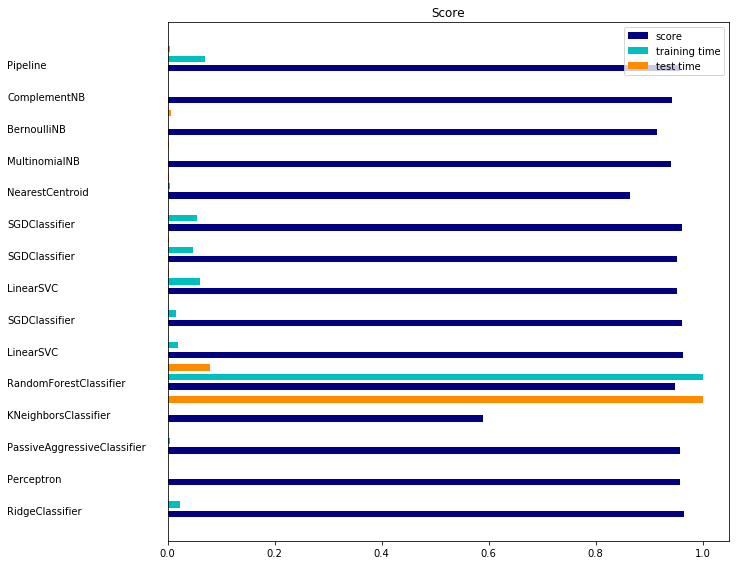

In [ ]:
results = []
opts['print_top10'] = 1
opts['print_cm'] = 1
opts['print_report'] = 1
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        (Perceptron(n_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X.transpose(), trainLabels, X2.transpose(), testLabels))
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3), X.transpose(), trainLabels, X2.transpose(), testLabels))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty,
                                           max_iter=5), X.transpose(), trainLabels, X2.transpose(), testLabels))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet",
                                       max_iter=5), X.transpose(), trainLabels, X2.transpose(), testLabels))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid(), X.transpose(), trainLabels, X2.transpose(), testLabels))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01), X.transpose(), trainLabels, X2.transpose(), testLabels))
results.append(benchmark(BernoulliNB(alpha=.01), X.transpose(), trainLabels, X2.transpose(), testLabels))
results.append(benchmark(ComplementNB(alpha=.1), X.transpose(), trainLabels, X2.transpose(), testLabels))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))]), X.transpose(), trainLabels, X2.transpose(), testLabels))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()



In [ ]:
testLabels = list(itertools.chain([1] * len(list(crabo_test)), [-1] * len(list(crsub_test))))
ypred = model.predict(X2.transpose())
print(classification_report(testLabels, ypred, target_names=['abo', 'sub'], digits=3))
print(confusion_matrix(testLabels, ypred))

             precision    recall  f1-score   support

        abo      0.869     0.891     0.880       193
        sub      0.963     0.955     0.959       576

avg / total      0.939     0.939     0.939       769

[[172  21]
 [ 26 550]]


In [ ]:
model.predict_proba(X2.transpose())

array([[ 0.49659214,  0.50340786],
       [ 0.09777801,  0.90222199],
       [ 0.1022115 ,  0.8977885 ],
       ..., 
       [ 0.98153536,  0.01846464],
       [ 0.78630818,  0.21369182],
       [ 0.94885418,  0.05114582]])

In [ ]:
[' '.join(testdocs[i]) for i, x in enumerate(testLabels != ypred) if x and testLabels[i] == 1]


In [ ]:
lsi = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=10)
lsi.print_topics(10)


[(0,
  u'0.247*"\u2022" + 0.230*"," + 0.192*"-" + 0.158*"the" + 0.145*"a" + 0.137*"*" + 0.130*":" + 0.123*"and" + 0.112*"is" + 0.111*"of"'),
 (1,
  u'-0.934*"\u2022" + 0.078*"," + 0.051*"the" + -0.050*"Hard" + 0.050*"a" + 0.047*"-" + 0.047*"*" + 0.041*"is" + 0.036*"!" + -0.035*"Features"'),
 (2,
  u'0.299*"*" + 0.231*"TO" + 0.229*"VIEW" + 0.207*"!" + 0.166*"IN" + 0.166*"ROOM" + 0.156*"AND" + 0.146*"!!" + 0.145*"FULL" + 0.128*"KITCHEN"'),
 (3,
  u'-0.557*"*" + 0.159*"VIEW" + 0.153*"TO" + -0.136*"Village" + 0.117*"ROOM" + 0.111*"IN" + 0.107*"AND" + 0.103*"FULL" + -0.097*"Side" + -0.092*"East"'),
 (4,
  u'0.457*"*" + 0.134*"condo" + 0.124*"Financial" + 0.109*"District" + 0.100*"," + 0.092*"Club" + 0.090*"condominium" + -0.089*"is" + 0.088*"-" + 0.086*"In"'),
 (5,
  u'-0.422*":" + -0.176*")" + -0.172*"(" + -0.156*"Case" + -0.148*"$" + -0.138*"com" + -0.131*"**" + -0.124*"more" + -0.115*"information" + -0.113*"For"'),
 (6,
  u'-0.162*"-" + -0.156*"Stainless" + -0.139*"Steel" + -0.137*"Renov

In [ ]:
ypred = model.predict(X.transpose())
print(classification_report(trainLabels, ypred, target_names=['abo', 'sub'], digits=3))


             precision    recall  f1-score   support

        abo      0.929     0.928     0.929      4096
        sub      0.953     0.954     0.953      6236

avg / total      0.944     0.944     0.944     10332



In [ ]:

opts['print_top10'] = 1
opts['print_cm'] = 1
opts['print_report'] = 1

benchmark(model, X.transpose(), trainLabels, X2.transpose(), [-1] * len(list(crsub)) + [1] * len(list(crjoin)))


________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.084s
test time:  0.001s
accuracy:   0.898
dimensionality: 19233
density: 0.803931
top 10 keywords per class:
spam: This 2018 pictures Columbia laundry Call doorman tile Contact email
ham: sublet ft ). artists :. artist Brooklyn am We I

classification report:
             precision    recall  f1-score   support

       spam       0.93      0.95      0.94      2234
        ham       0.67      0.59      0.63       379

avg / total       0.89      0.90      0.90      2613

confusion matrix:
[[2123  111]
 [ 155  224]]



('RidgeClassifier',
 0.89820130118637587,
 0.08443093299865723,
 0.000762939453125)

In [ ]:
grid_svm.decision_function([testdocs[i] for i in np.where(grid_svm.predict(testdocs) > 0.0)[0]])
[(scores[i],crtest_desc[i]) for i, x in enumerate(crtest_labels != predict) if x and crtest_labels[i] == 1]